# 3. Modelado, Evaluación y Selección (MLflow Pipeline)

**Objetivo:** Construir un pipeline de entrenamiento robusto que integre el conocimiento adquirido en el análisis exploratorio (EDA) y en la sección de feature engineering y compare múltiples algoritmos utilizando la métrica **F1-Score**.

**Estrategia:**
1.  **Pipeline Scikit-learn:** Encapsular preprocesamiento y modelo para garantizar reproducibilidad.
2.  **Feature Engineering "In-Pipeline":** Calcular `BalanceSalaryRatio` y `TenureAgeRatio`.
3.  **Tracking con MLflow:** Registrar cada experimento para comparar métricas objetivamente.
4.  **Optimización:** Ajustar hiperparámetros del modelo ganador.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
import os
from pathlib import Path
import sys

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

from src.config import RAW_TRAIN_PATH, RAW_TEST_PATH, RANDOM_SEED, NUMERIC_FEATURES, CATEGORICAL_FEATURES

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
os.makedirs("../models", exist_ok=True) 
os.makedirs("../submissions", exist_ok=True)

df_train = pd.read_csv(RAW_TRAIN_PATH)
df_test = pd.read_csv(RAW_TEST_PATH)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

db_path = os.path.join(os.getcwd(), "..", "mlflow.db") 
tracking_uri = f"sqlite:///{db_path}"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Bank_Churn_Prediction")

print(f"✅ MLflow logueando en: {tracking_uri}")

[2025-11-22 19:38:25][src.config][INFO] Cargando parámetros desde /home/miguel/Documents/UIMP/aprendizaje_automatico/ml-finance-churn-model/config/params.yaml
[2025-11-22 19:38:25][src.config][INFO] Features dinámicas cargadas desde selected_features.json
[2025-11-22 19:38:25][src.config][INFO] Features dinámicas: comments='Variables seleccionadas automaticamente por Boruta' date='2025-11-19 23:04' features=FeaturesDetail(numeric=['Age', 'Balance', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'CreditScore', 'EstimatedSalary'], categorical=['Geography', 'Gender', 'NumOfProducts'])
[2025-11-22 19:38:25][src.config][INFO] 🚀 Usando configuración de features DINÁMICA (Boruta).


Train shape: (8000, 13)
Test shape: (2000, 12)


2025/11/22 19:38:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/22 19:38:26 INFO mlflow.store.db.utils: Updating database tables
2025-11-22 19:38:26 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-22 19:38:26 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-22 19:38:26 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-22 19:38:26 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/11/22 19:38:27 INFO mlflow.tracking.fluent: Experiment with name 'Bank_Churn_Prediction' does not exist. Creating a new experiment.


✅ MLflow logueando en: sqlite:////home/miguel/Documents/UIMP/aprendizaje_automatico/ml-finance-churn-model/notebooks/../mlflow.db


## 1. Definición de Variables (Golden Features)
Basado en el análisis de Boruta previo, definimos explícitamente qué variables entran al modelo.
* **Nota:** `EstimatedSalary` y `Tenure` NO están en la lista final, pero se usarán internamente para calcular los ratios antes de ser descartadas.

In [12]:
print("Features seleccionadas para el modelo final:", NUMERIC_FEATURES + CATEGORICAL_FEATURES)

Features seleccionadas para el modelo final: ['Age', 'Balance', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'CreditScore', 'EstimatedSalary', 'Geography', 'Gender', 'NumOfProducts']


## 2. Ingeniería de Características en el Pipeline
Creamos una clase `FeatureEngineer` compatible con Scikit-learn. Esto es crucial: permite que cuando lleguen los datos de Test (que no tienen los ratios calculados), el pipeline los genere automáticamente sin intervención manual.

In [2]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        X_new['HasBalance'] = (X_new['Balance'] > 0).astype(int)
        X_new['LogBalance'] = np.log1p(X_new['Balance'])
        X_new['BalancePerProduct'] = X_new['Balance'] / X_new['NumOfProducts'].replace(0, 1)
        X_new['BalanceSalaryRatio'] = X_new['Balance'] / X_new['EstimatedSalary'].replace(0, 1)

        X_new['Age_Active_Interaction'] = X_new['Age'] * X_new['IsActiveMember']
        X_new['TenureAgeRatio'] = X_new['Tenure'] / X_new['Age'].replace(0, 1)
        X_new['CreditScore_Age_Ratio'] = X_new['CreditScore'] / X_new['Age'].replace(0, 1)

        X_new['Products_Active_Interaction'] = X_new['NumOfProducts'] * X_new['IsActiveMember']
        X_new['HasMultipleProducts'] = (X_new['NumOfProducts'] > 1).astype(int)

        X_new['CreditScore_Salary_Ratio'] = X_new['CreditScore'] / (X_new['EstimatedSalary'] / 1000).replace(0, 1)
        X_new['HighCreditScore'] = (X_new['CreditScore'] > 700).astype(int)

        X_new['CustomerEngagement'] = (
            X_new['IsActiveMember'] + X_new['HasCrCard'] +
            (X_new['NumOfProducts'] > 1).astype(int)
        )

        X_new['RiskScore'] = (
            (X_new['Age'] > 50).astype(int) +
            (X_new['NumOfProducts'] > 2).astype(int) +
            (1 - X_new['IsActiveMember']) +
            (X_new['Balance'] == 0).astype(int)
        )

        return X_new

In [3]:
class DropFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer para eliminar columnas que no aportan valor al modelo.

    Parámetros:
    -----------
    features_to_drop : list
        Lista de nombres de columnas a eliminar (ej: ['CustomerId', 'Surname'])

    Ejemplos:
    ---------
    >>> # Uso básico
    >>> drop = DropFeatures(features_to_drop=['CustomerId', 'Surname'])
    >>> X_clean = drop.fit_transform(X)

    >>> # En un pipeline
    >>> pipeline = Pipeline([
    ...     ('drop', DropFeatures(['CustomerId', 'Surname'])),
    ...     ('scaler', StandardScaler()),
    ...     ('model', LogisticRegression())
    ... ])
    """
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop if features_to_drop is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Elimina las columnas especificadas si existen en el DataFrame"""
        X_out = X.copy()

        cols_to_drop = [col for col in self.features_to_drop if col in X_out.columns]

        if cols_to_drop:
            X_out = X_out.drop(columns=cols_to_drop)

        return X_out

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop' 
)

## 3. Experimentación con MLflow
Evaluamos 4 modelos distintos utilizando **Validación Cruzada (5-Folds)** y optimizando para la métrica **F1-Score** (dado el desbalanceo de clases).

2025/11/22 19:38:39 INFO mlflow.tracking.fluent: Experiment with name 'Bank_Churn_Prediction_Final' does not exist. Creating a new experiment.


Iniciando experimentos...

--- Entrenando y registrando: CatBoost ---
Modelo: CatBoost | F1 SMOTE: 0.6130 | Mejor Umbral: 0.5310


2025/11/22 19:39:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 19:39:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/22 19:39:38 INFO mlflow.store.db.utils: Updating database tables
2025-11-22 19:39:38 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-22 19:39:38 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Successfully registered model 'churn-catboost'.
Created version '1' of model 'churn-catboost'.



--- Entrenando y registrando: LGBM ---


2025/11/22 19:45:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modelo: LGBM | F1 SMOTE: 0.5991 | Mejor Umbral: 0.5225


Successfully registered model 'churn-lgbm'.
Created version '1' of model 'churn-lgbm'.



--- Entrenando y registrando: XGBoost ---
Modelo: XGBoost | F1 SMOTE: 0.5726 | Mejor Umbral: 0.6635


2025/11/22 19:46:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'churn-xgboost'.
Created version '1' of model 'churn-xgboost'.



--- Entrenando y registrando: Random_Forest ---


2025/11/22 19:47:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modelo: Random_Forest | F1 SMOTE: 0.6019 | Mejor Umbral: 0.5393


Successfully registered model 'churn-random-forest'.
Created version '1' of model 'churn-random-forest'.



--- Entrenando y registrando: MLP_Network ---


2025/11/22 19:47:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modelo: MLP_Network | F1 SMOTE: 0.6078 | Mejor Umbral: 0.4830


Successfully registered model 'churn-mlp-network'.
Created version '1' of model 'churn-mlp-network'.



--- Entrenando y registrando: Gaussian_NB ---


2025/11/22 19:47:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modelo: Gaussian_NB | F1 SMOTE: 0.5338 | Mejor Umbral: 0.0008


Successfully registered model 'churn-gaussian-nb'.
Created version '1' of model 'churn-gaussian-nb'.



--- Entrenando y registrando: KNN ---
Modelo: KNN | F1 SMOTE: 0.5186 | Mejor Umbral: 0.4847


2025/11/22 19:47:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'churn-knn'.
Created version '1' of model 'churn-knn'.


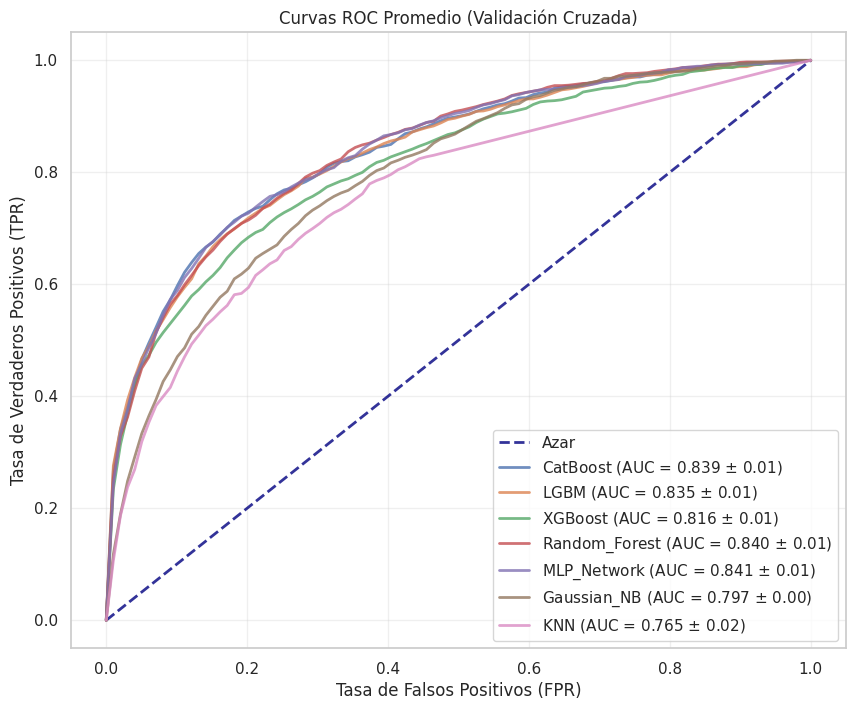

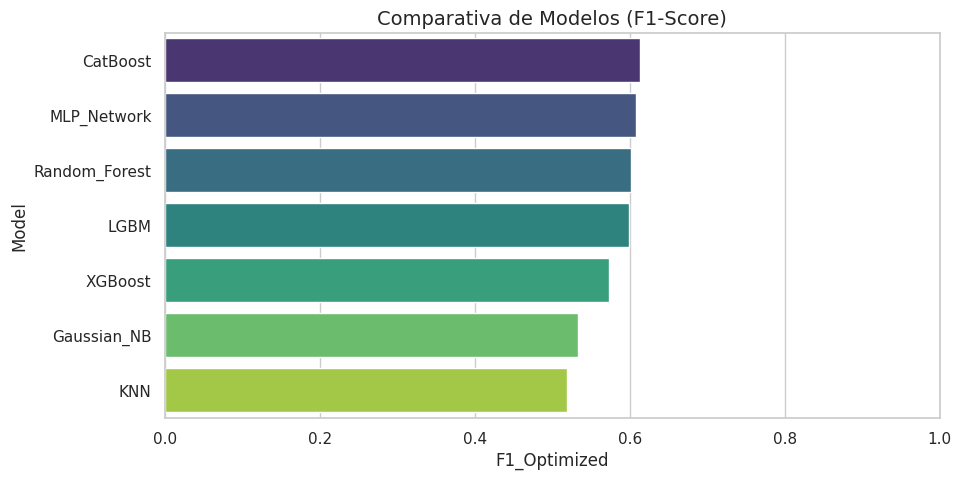

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from mlflow.models.signature import infer_signature

X = df_train.drop(columns=['Exited'], errors='ignore')
y = df_train['Exited']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42),
    "LGBM": LGBMClassifier(is_unbalance=True, random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=4, eval_metric='logloss', random_state=42),
    "Random_Forest": RandomForestClassifier(class_weight='balanced', n_estimators=150, max_depth=10, random_state=42),
    "MLP_Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.01,
        batch_size=64,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ),
    "Gaussian_NB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance')
}

mlflow.set_experiment("Bank_Churn_Prediction_Final")
results_advanced = []
results = []

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy', label='Azar', alpha=0.8)
mean_fpr = np.linspace(0, 1, 100)

print("Iniciando experimentos...")
for name, model in models.items():
    with mlflow.start_run(run_name=f"{name} - Baseline Experiment") as run:
        print(f"\n--- Entrenando y registrando: {name} ---")
        
        # 1. Tags para contexto
        mlflow.set_tag("model_type", name)
        mlflow.set_tag("experiment_stage", "Baseline Comparison")
        
        pipeline = ImbPipeline(steps=[
            ('drop_features', DropFeatures(features_to_drop=['CustomerId', 'Surname'])),
            ('engineer', FeatureEngineer()),
            ('preprocessor', preprocessor),
            ('resampler', SMOTE(random_state=42, sampling_strategy=0.5)),
            ('classifier', model)
        ])
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        fold_f1s = []
        best_thresholds = []
        tprs = []
        aucs = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            pipeline.fit(X_train_fold, y_train_fold)
            
            y_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            fpr, tpr, _ = roc_curve(y_val_fold, y_proba)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
            # --- THRESHOLD TUNING ---
            precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba)
            
            # Calcular F1 para todos los umbrales posibles
            # F1 = 2 * (P * R) / (P + R)
            numerator = 2 * (precisions * recalls)
            denominator = (precisions + recalls)
            # Evitar división por cero
            f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
            
            best_idx = np.argmax(f1_scores)
            fold_f1s.append(f1_scores[best_idx])
            best_thresholds.append(thresholds[best_idx])
        
        avg_f1 = np.mean(fold_f1s)
        avg_thresh = np.mean(best_thresholds)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr,
                 label=f'{name} (AUC = {mean_auc:.3f} $\pm$ {std_auc:.2f})',
                 lw=2, alpha=0.8)
        
        print(f"Modelo: {name} | F1 SMOTE: {avg_f1:.4f} | Mejor Umbral: {avg_thresh:.4f}")
        
        # 2. Firma del modelo
        signature = infer_signature(X_val, pipeline.predict(X_val))
        
        # 3. Registro del modelo en MLflow Model Registry
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            signature=signature,
            registered_model_name=f"churn-{name.lower().replace('_', '-')}"
        )
        # 3. Loguear en MLflow
        mlflow.log_param("resampling", "SMOTE_0.5")
        mlflow.log_metric("f1_mean_opt", avg_f1)
        mlflow.log_metric("optimal_threshold", avg_thresh)
        
        results_advanced.append({
            "Model": name,
            "F1_Optimized": avg_f1,
            "Threshold": avg_thresh,
            "Instance": model
        })

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Promedio (Validación Cruzada)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

df_results = pd.DataFrame(results_advanced).sort_values("F1_Optimized", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='F1_Optimized', y='Model', palette='viridis')
plt.title('Comparativa de Modelos (F1-Score)', fontsize=14)
plt.xlim(0, 1)
plt.show()

## 5. Evaluación Final y Matriz de Confusión
Evaluamos el mejor modelo sobre todo el conjunto de entrenamiento para ver dónde falla (Falsos Positivos vs Falsos Negativos). Para ello evaluaremos primero el modelo obtenido con el threshold optimizado, aquel que es recuperado de mlflow, y posteriormente evaluaremos el modelo con el threshold por defecto.

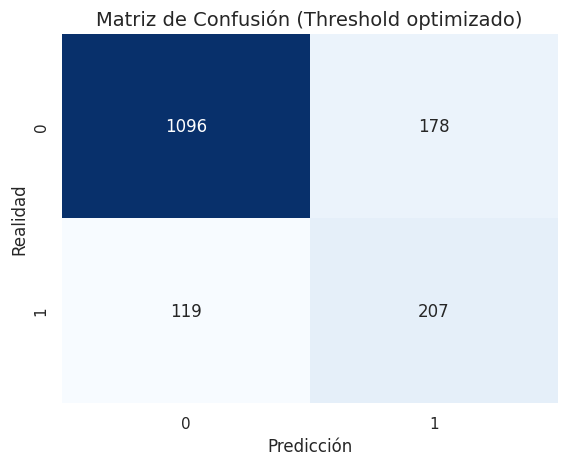

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1274
           1       0.54      0.63      0.58       326

    accuracy                           0.81      1600
   macro avg       0.72      0.75      0.73      1600
weighted avg       0.83      0.81      0.82      1600



In [8]:
loaded_model = mlflow.sklearn.load_model("models:/churn-catboost/1")

predictions = loaded_model.predict(X_val)
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Threshold optimizado)', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y_val, predictions))

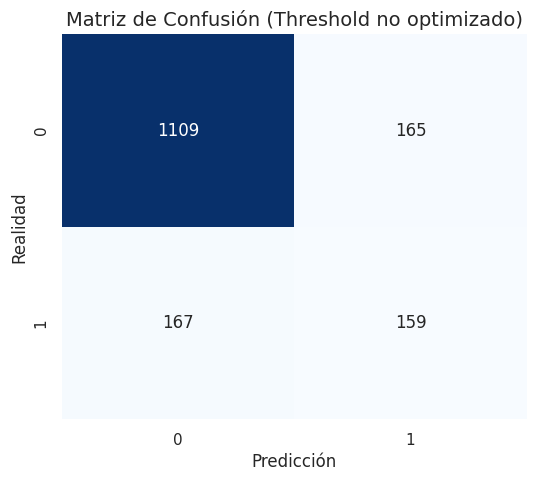

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1274
           1       0.49      0.49      0.49       326

    accuracy                           0.79      1600
   macro avg       0.68      0.68      0.68      1600
weighted avg       0.79      0.79      0.79      1600



In [10]:
catboost_pipeline = ImbPipeline(steps=[
    ('drop_features', DropFeatures(features_to_drop=['CustomerId', 'Surname'])),
    ('engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('resampler', SMOTE(random_state=42, sampling_strategy=0.5)),
    ('classifier', model)
])
model = catboost_pipeline.fit(X_train, y_train)
y_pred = catboost_pipeline.predict(X_val)

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Threshold no optimizado)', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

## 6. Generación del Envío (Submission) para Kaggle
Aplicamos el pipeline completo al conjunto de test (`test.csv`). Gracias a la clase `FeatureEngineer`, los ratios se calculan automáticamente.

In [ ]:
from datetime import datetime
ids = df_test['CustomerId']

predictions = loaded_model.predict(df_test)

submission = pd.DataFrame({
    'CustomerId': ids,
    'Exited': predictions
})

suffix = datetime.now().strftime("_%Y%m%d_%H%M%S")
save_path = f'../submissions/submission_catboost_optimized{suffix}.csv'
submission.to_csv(save_path, index=False)

print(f"¡Archivo generado! Guardado en: {save_path}")
print(submission.head())

¡Archivo generado! Guardado en: ../submissions/submission_catboost_optimized_20251122_195601.csv
   CustomerId  Exited
0    15764618       0
1    15626385       0
2    15687413       0
3    15759067       1
4    15614049       0
